In [1]:
# Import required libraries
import nltk
import pickle
import pandas as pd
import tensorflow as tf
from keras import layers
from keras.models import Sequential, load_model
#from data_sanitize import clean_data
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


# download stopwords 
#nltk.download('stopwords')


In [2]:
# Load in the data set as required
df = pd.read_csv('../input/d/syedsaqlainhussain/sql-injection-dataset/sqli.csv', encoding = 'utf-16')


In [3]:
# Vectorize the dataset
vectorizer = CountVectorizer(min_df = 2, max_df = 0.7, max_features = 4096, stop_words = nltk.corpus.stopwords.words('english'))

# initialize variables X and y
y = df['Label']
X = vectorizer.fit_transform(df['Sentence'].values.astype('U')).toarray()

X.shape


(4200, 4096)

In [4]:
# reshape the X variable into a matrix
X.shape = (4200, 64, 64, 1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# reshape train and test data
tested = X_test.copy()
tested.shape = (tested.shape[0], tested.shape[1] * tested.shape[2])
trained = X_train.copy()
trained.shape = (X_train.shape[0], X_train.shape[1] * X_train.shape[2])

In [6]:
# define classifiers for the research
# Naive Bayes
nb = GaussianNB()
nb.fit(trained, y_train)
nb_prediction = nb.predict(tested)

# Decision Tree
dt = tree.DecisionTreeClassifier()
dt = dt.fit(trained, y_train)
dt_prediction = dt.predict(tested)

# K Nearest Neighbor
knn = KNeighborsClassifier(n_neighbors = 3)
knn = knn.fit(trained, y_train)
knn_prediction = knn.predict(tested)

# Support Vector Machine
svm = SVC(gamma = 'auto')
svm = svm.fit(trained, y_train)
svm_prediction = svm.predict(tested)


In [7]:
# import keras methods
import keras
from keras.models import Model

# CNN
epochs = 20
batch_size = 128

# Create model
model = Sequential()
model.add(layers.Conv2D(32, kernel_size = (3, 3), activation = tf.nn.relu, input_shape = (64, 64, 1)))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation = tf.nn.relu))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation = tf.nn.relu))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [8]:
# compile CNN model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

In [9]:
cnn = model.fit(X_train, y_train, epochs = epochs, verbose = True, validation_data = (X_test, y_test), batch_size = batch_size)

Epoch 1/20
27/27 [==============================] - 10s 312ms/step - loss: 0.4390 - accuracy: 0.7515 - val_loss: 0.3317 - val_accuracy: 0.8643
Epoch 2/20
27/27 [==============================] - 8s 298ms/step - loss: 0.2142 - accuracy: 0.9140 - val_loss: 0.1700 - val_accuracy: 0.9310
Epoch 3/20
27/27 [==============================] - 8s 297ms/step - loss: 0.1535 - accuracy: 0.9348 - val_loss: 0.1465 - val_accuracy: 0.9333
Epoch 4/20
27/27 [==============================] - 9s 319ms/step - loss: 0.1286 - accuracy: 0.9432 - val_loss: 0.1336 - val_accuracy: 0.9393
Epoch 5/20
27/27 [==============================] - 8s 296ms/step - loss: 0.1110 - accuracy: 0.9506 - val_loss: 0.1327 - val_accuracy: 0.9345
Epoch 6/20
27/27 [==============================] - 8s 299ms/step - loss: 0.0970 - accuracy: 0.9563 - val_loss: 0.1182 - val_accuracy: 0.9500
Epoch 7/20
27/27 [==============================] - 8s 292ms/step - loss: 0.0891 - accuracy: 0.9598 - val_loss: 0.1113 - val_accuracy: 0.9548
Epoch

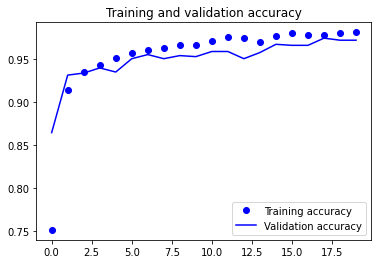

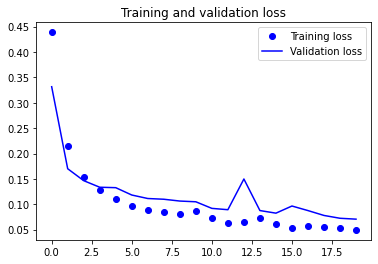

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = cnn.history['accuracy']
val_accuracy = cnn.history['val_accuracy']
loss = cnn.history['loss']
val_loss = cnn.history['val_loss']
epochs = range(len(accuracy))

# plot accuracy values
plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# plot loss values
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
# add dropout to reduce overfitting
model = Sequential()
model.add(layers.Conv2D(32, kernel_size = (3, 3), activation = tf.nn.relu, input_shape = (64, 64, 1)))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation = tf.nn.relu))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation = tf.nn.relu))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(256, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [12]:
# show model summary
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)      

In [13]:
cnn_dropout = model.fit(X_train, y_train, epochs = 20, verbose = True, validation_data = (X_test, y_test), batch_size = batch_size)

Epoch 1/20
27/27 [==============================] - 10s 339ms/step - loss: 0.4335 - accuracy: 0.7515 - val_loss: 0.3492 - val_accuracy: 0.8690
Epoch 2/20
27/27 [==============================] - 9s 328ms/step - loss: 0.2587 - accuracy: 0.9068 - val_loss: 0.2044 - val_accuracy: 0.9048
Epoch 3/20
27/27 [==============================] - 10s 354ms/step - loss: 0.1818 - accuracy: 0.9244 - val_loss: 0.1753 - val_accuracy: 0.9238
Epoch 4/20
27/27 [==============================] - 9s 327ms/step - loss: 0.1571 - accuracy: 0.9307 - val_loss: 0.1468 - val_accuracy: 0.9286
Epoch 5/20
27/27 [==============================] - 9s 327ms/step - loss: 0.1318 - accuracy: 0.9414 - val_loss: 0.1356 - val_accuracy: 0.9440
Epoch 6/20
27/27 [==============================] - 9s 328ms/step - loss: 0.1210 - accuracy: 0.9461 - val_loss: 0.1462 - val_accuracy: 0.9405
Epoch 7/20
27/27 [==============================] - 9s 353ms/step - loss: 0.1258 - accuracy: 0.9470 - val_loss: 0.1239 - val_accuracy: 0.9500
Epoc

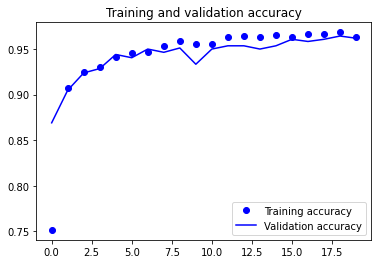

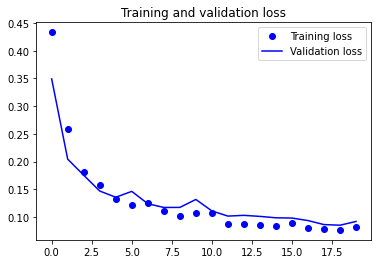

In [14]:
accuracy = cnn_dropout.history['accuracy']
val_accuracy = cnn_dropout.history['val_accuracy']
loss = cnn_dropout.history['loss']
val_loss = cnn_dropout.history['val_loss']
epochs = range(len(accuracy))

# plot accuracy values
plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# plot loss values
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
cnn_prediction = model.predict(X_test)

# convert array into one-hot encoding vector
for i in range(len(cnn_prediction)):
    if cnn_prediction[i] > 0.5:
        cnn_prediction[i] = 1
    elif cnn_prediction[i] <= 0.5:
        cnn_prediction[i] = 0

In [16]:
# save model for future use
model.save('cnn_model.h5')
with open('cnn_vectorizer', 'wb') as fin:
    pickle.dump(vectorizer, fin)

In [17]:
# instantiate confusion matrix
def confusion_matrix(true_value, predicted_value):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    # loop over params
    for i, j in zip(true_value, predicted_value):
        if i == 1:
            if i == j:
                tp += 1
            elif i != j:
                fn += 1
                
        elif i == 0:
            if i == j:
                tn += 1
            elif i != j:
                fp += 1
                
    return (tp, tn, fp, fn)
                
# set colors for bar chart
colors = ['#0069c0', '#008ac5', '#00a9b5', '#00c698', '#1fe074'] #, '#0E3386', '#BA0021', '#E81828', '#473729', '#D31145', '#0C2340', '#005A9C', '#BD3039', '#EB6E1F', '#C41E3A', '#33006F', '#C6011F', '#004687', '#CE1141', '#134A8E', '#27251F', '#FDB827', '#0C2340', '#FD5A1E', '#00A3E0', '#ffc52f', '#003831', '#005C5C', '#E31937', '#8FBCE6']

 For CNN 
 Accuracy : 0.9619047619047619 
 False Alarm Ratio : 0.8125 
 Recall : 0.9761904761904762 
 Precision : 0.9044117647058824 
 F1_Score : 0.9389312977099237


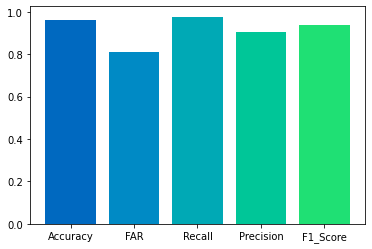

In [18]:
# compute evaluation criteria

# Convolutional Neural Network
tp, tn, fp, fn = confusion_matrix(y_test, cnn_prediction)
accuracy = (tp + tn) / (tp + fp + fn + tn)
false_alarm_ratio = fp / (fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * ((recall * precision) / (recall + precision))
cnn_dict = {'Accuracy': accuracy, 'FAR': false_alarm_ratio, 'Recall': recall, 'Precision': precision, 'F1_Score': f1_score}

print(" For CNN \n Accuracy : {0} \n False Alarm Ratio : {1} \n Recall : {2} \n Precision : {3} \n F1_Score : {4}".format(accuracy, false_alarm_ratio, recall, precision, f1_score))
plt.bar(*zip(*cnn_dict.items()), color = colors)
plt.show()

 For Naive Bayes 
 Accuracy : 0.9773809523809524 
 False Alarm Ratio : 1.0 
 Recall : 1.0 
 Precision : 0.9298892988929889 
 F1_Score : 0.9636711281070746


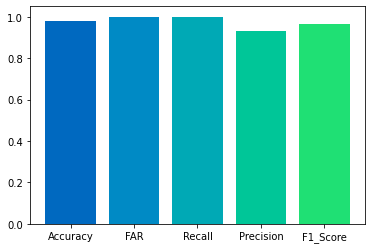

In [19]:
# Naive Bayes
tp, tn, fp, fn = confusion_matrix(y_test, nb_prediction)
accuracy = (tp + tn) / (tp + fp + fn + tn)
false_alarm_ratio = fp / (fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * ((recall * precision) / (recall + precision))
nb_dict = {'Accuracy': accuracy, 'FAR': false_alarm_ratio, 'Recall': recall, 'Precision': precision, 'F1_Score': f1_score}

print(" For Naive Bayes \n Accuracy : {0} \n False Alarm Ratio : {1} \n Recall : {2} \n Precision : {3} \n F1_Score : {4}".format(accuracy, false_alarm_ratio, recall, precision, f1_score))
plt.bar(*zip(*nb_dict.items()), color = colors)
plt.show()

 For Decision Tree 
 Accuracy : 0.875 
 False Alarm Ratio : 1.0 
 Recall : 1.0 
 Precision : 0.7058823529411765 
 F1_Score : 0.8275862068965517


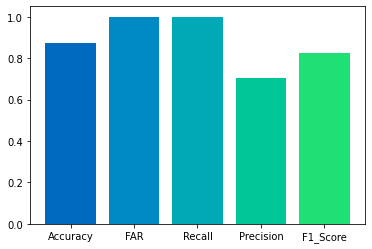

In [20]:
# Decision Tree
tp, tn, fp, fn = confusion_matrix(y_test, dt_prediction)
accuracy = (tp + tn) / (tp + fp + fn + tn)
false_alarm_ratio = fp / (fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * ((recall * precision) / (recall + precision))
dt_dict = {'Accuracy': accuracy, 'FAR': false_alarm_ratio, 'Recall': recall, 'Precision': precision, 'F1_Score': f1_score}

print(" For Decision Tree \n Accuracy : {0} \n False Alarm Ratio : {1} \n Recall : {2} \n Precision : {3} \n F1_Score : {4}".format(accuracy, false_alarm_ratio, recall, precision, f1_score))
plt.bar(*zip(*dt_dict.items()), color = colors)
plt.show()

 For K Nearest Neighbor 
 Accuracy : 0.5976190476190476 
 False Alarm Ratio : 1.0 
 Recall : 1.0 
 Precision : 0.4271186440677966 
 F1_Score : 0.5985748218527316


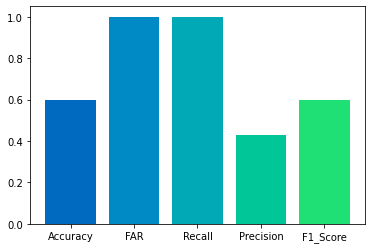

In [21]:
# K Nearest Neighbor
tp, tn, fp, fn = confusion_matrix(y_test, knn_prediction)
accuracy = (tp + tn) / (tp + fp + fn + tn)
false_alarm_ratio = fp / (fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * ((recall * precision) / (recall + precision))
knn_dict = {'Accuracy': accuracy, 'FAR': false_alarm_ratio, 'Recall': recall, 'Precision': precision, 'F1_Score': f1_score}

print(" For K Nearest Neighbor \n Accuracy : {0} \n False Alarm Ratio : {1} \n Recall : {2} \n Precision : {3} \n F1_Score : {4}".format(accuracy, false_alarm_ratio, recall, precision, f1_score))
plt.bar(*zip(*knn_dict.items()), color = colors)
plt.show()

 For Support Vector Machine 
 Accuracy : 0.7642857142857142 
 False Alarm Ratio : 0.0 
 Recall : 0.21428571428571427 
 Precision : 1.0 
 F1_Score : 0.35294117647058826


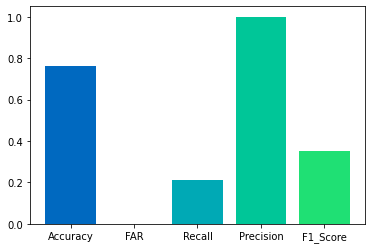

In [22]:
# Support Vector Machine
tp, tn, fp, fn = confusion_matrix(y_test, svm_prediction)
accuracy = (tp + tn) / (tp + fp + fn + tn)
false_alarm_ratio = fp / (fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * ((recall * precision) / (recall + precision))
svm_dict = {'Accuracy': accuracy, 'FAR': false_alarm_ratio, 'Recall': recall, 'Precision': precision, 'F1_Score': f1_score}

print(" For Support Vector Machine \n Accuracy : {0} \n False Alarm Ratio : {1} \n Recall : {2} \n Precision : {3} \n F1_Score : {4}".format(accuracy, false_alarm_ratio, recall, precision, f1_score))
plt.bar(*zip(*svm_dict.items()), color = colors)
plt.show()

In [23]:
#from data_sanitize import clean_data

# detect SQLI with CNN
input_val = "LIMIT 1-- id=1') OR SLEEP(25)=0 LIMIT 1-- id=1)) OR SLEEP(25)=0 LIMIT 1-- id=SELECT SLEEP(25)--"
#input_val = clean_data(input_val)
input_val = [input_val]
input_val = vectorizer.transform(input_val).toarray()
input_val.shape = (1, 64, 64, 1)
result = model.predict(input_val)
print(result > 0.5)

[[ True]]


In [25]:
input_val = "https://pastebin.com/Tdvi8vgK"
#input_val = clean_data(input_val)
input_val = [input_val]
input_val = vectorizer.transform(input_val).toarray()
input_val.shape = (1, 64, 64, 1)
result = model.predict(input_val)
print(result > 0.5)

[[False]]
